In [2]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from collections import defaultdict

Using TensorFlow backend.


In [2]:
def show(X):
    display(Image.fromarray(X))

In [3]:
train_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TRAIN_NOSEG_64.npy')
test_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_NOSEG_64.npy')
train = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TRAIN.csv')
test = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TEST.csv')
test_id = test.image.values

In [4]:
test_stg2 = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/TEST_STG2.csv')
test_stg2_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_STG2_NOSEG_64.npy')
test_stg2_id = test_stg2.image.values

In [9]:
train_data_rl = train_data[:,:,::-1,:]

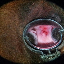

In [10]:
show(train_data_rl[800])

In [11]:
def rotation(image, angle):
    assert image.shape[-1] == 3
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    return img_rotation

In [12]:
rot_num = 12
rot_imgs = defaultdict(list)
for i in range(train_data.shape[0]):
    for rot in range(int(360/rot_num),360,int(360/rot_num)):
        rot_img = rotation(train_data[i,:,:,:], rot)
        rot_imgs[rot].append(rot_img)

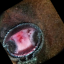

In [13]:
show(rot_imgs[30][800])

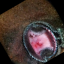

In [14]:
show(rot_imgs[120][800])

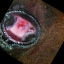

In [15]:
show(rot_imgs[330][800])

In [16]:
train_data = np.concatenate([train_data, train_data_ud, train_data_rl,\
                             np.array(rot_imgs[30]),np.array(rot_imgs[60]),\
                             np.array(rot_imgs[90]),np.array(rot_imgs[120]),\
                             np.array(rot_imgs[150]),np.array(rot_imgs[180]),\
                             np.array(rot_imgs[210]),np.array(rot_imgs[240]),\
                             np.array(rot_imgs[270]),np.array(rot_imgs[300]),\
                             np.array(rot_imgs[330])])

In [17]:
train_data.shape

(114968, 64, 64, 3)

### 增加亮度 

In [18]:
train_data_light = (train_data * 1.2).clip(0,255).astype(np.uint8)

In [19]:
train_data_light.shape

(114968, 64, 64, 3)

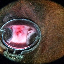

In [20]:
show(train_data_light[800])

### 減少亮度 

In [21]:
train_data_non_light = (train_data * 0.8).clip(0,255).astype(np.uint8)

In [22]:
train_data_non_light.shape

(114968, 64, 64, 3)

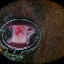

In [23]:
show(train_data_non_light[800])

### 組合

In [24]:
train_X = np.concatenate([train_data,train_data_light,train_data_non_light])

In [25]:
train_X.shape

(344904, 64, 64, 3)

In [26]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
train_Y = np.concatenate([train_target for i in range(14*3)])

In [27]:
train_X.shape, train_Y.shape

((344904, 64, 64, 3), (344904,))

In [29]:
random_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace = False)

In [30]:
train_X = train_X[random_index]
train_Y = train_Y[random_index]

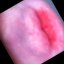

In [31]:
show(train_X[800])

In [32]:
x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_X, train_Y, test_size = 0.1, random_state=17)

In [33]:
x_train.shape, x_val_train.shape, y_train.shape, y_val_train.shape

((310413, 64, 64, 3), (34491, 64, 64, 3), (310413,), (34491,))

In [63]:
train_X.shape

(344904, 64, 64, 3)

In [64]:
pwd

'/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/Final_Model'

In [67]:
#%timeit np.save('/home/Kaggle_Cervical_Cancer_Screening/Image_Data/Data_NOSEG_30W_Feature.npy', train_X)

In [68]:
#%timeit np.save('/home/Kaggle_Cervical_Cancer_Screening/Image_Data/Data_NOSEG_30W_Label.npy', train_Y)

In [34]:
# 3種 Type
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [35]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras import backend as K

In [38]:
model = Sequential()
model.add(Reshape((64,64,3), input_shape = x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
__________

In [39]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [40]:
x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

In [41]:
x_test_stg2= test_stg2_data.astype('float32')
x_test_stg2 /= 255

In [42]:
model.fit(x_train, y_train, validation_data = (x_val_train, y_val_train), epochs = 20, batch_size = 128)

Train on 310413 samples, validate on 34491 samples
Epoch 1/20
310413/310413 [==============================] - 103s - loss: 0.9683 - acc: 0.5404 - val_loss: 0.9167 - val_acc: 0.5505

In [43]:
pred = model.predict_proba(x_test)

416/512 [=======================>......] - ETA: 0s

In [44]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])
df['image_name'] = test_id
df = df[['image_name','Type_1','Type_2','Type_3']]

In [45]:
sample_submission =\
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/sample_submission.csv')

In [46]:
for name in sample_submission['image_name']:
    #print(name)
    #sub[name] = df[df['image_name'] == name][['Type_1','Type_2','Type_3']].values.tolist()[0]
    #print(name)
    Type_1 = df.loc[df['image_name'] == name, 'Type_1']
    Type_2 = df.loc[df['image_name'] == name, 'Type_2']
    Type_3 = df.loc[df['image_name'] == name, 'Type_3']
    
    Type_1_index = Type_1.index[0]
    Type_2_index = Type_2.index[0]
    Type_3_index = Type_3.index[0]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_1'] = Type_1[Type_1_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_2'] = Type_2[Type_2_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_3'] = Type_3[Type_3_index]

In [70]:
sample_submission.head()

image_name    Type_1    Type_2    Type_3
0      0.jpg  0.843406  0.091033  0.065562
1      1.jpg  0.001734  0.000496  0.997771
2      2.jpg  0.977619  0.022364  0.000018
3      3.jpg  0.000005  0.919446  0.080549
4      4.jpg  0.000538  0.003351  0.996111

In [48]:
True_outcome = pd.read_csv('/home/dataset/solution_stg1_release.csv')

In [71]:
True_outcome.head()

image_name  Type_1  Type_2  Type_3
0      0.jpg       0       1       0
1      1.jpg       0       1       0
2      2.jpg       1       0       0
3      3.jpg       0       0       1
4      4.jpg       0       0       1

In [50]:
Pred = sample_submission[["Type_1","Type_2","Type_3"]].values

In [51]:
Ober = True_outcome[["Type_1","Type_2","Type_3"]].values

In [52]:
func = lambda y, p: y * np.log(max(min(p, 1-10e-15),10e-15))
log_loss = 0.0
for i in range(0, sample_submission.shape[0], 1):

    log_loss += np.sum(np.array(list(map(func, Ober[i], Pred[i]))))
    #print(log_loss)
log_loss /= (-1.) * sample_submission.shape[0]

In [53]:
log_loss

1.6558029179923774

In [54]:
pred_stg2 = model.predict_proba(x_test_stg2)
df_stg2 = pd.DataFrame(pred_stg2, columns=['Type_1','Type_2','Type_3'])
df_stg2['image_name'] = test_stg2_id
df_stg2 = df_stg2[['image_name','Type_1','Type_2','Type_3']]

3456/3506 [============================>.] - ETA: 0s

In [55]:
df_stg2.head()

image_name        Type_1    Type_2    Type_3
0  12708.jpg  6.076054e-07  0.000007  0.999992
1  13284.jpg  1.977857e-03  0.000142  0.997880
2  11551.jpg  1.389182e-05  0.032949  0.967037
3  11151.jpg  7.358130e-04  0.954005  0.045259
4  11643.jpg  9.987686e-01  0.001229  0.000002

In [56]:
df_stg2.shape

(3506, 4)

In [57]:
df_stg2_submission = pd.concat([sample_submission, df_stg2]).reset_index(drop=True)

In [58]:
df_stg2_submission.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB02_stg2.csv', index=False)